<a href="https://colab.research.google.com/github/micheljoezakhia/Colab-Lab-Net-Project/blob/main/Lab_Network_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📥 Loading data...
✅ Model trained successfully on 2023 data!


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

💾 Saved predictions → predicted_2024.csv (25 coins)

📊 Evaluation Results:
MAE (Mean Absolute Error): 5656.0916
R² Score: 0.6071
Mean % Error: 49.81%


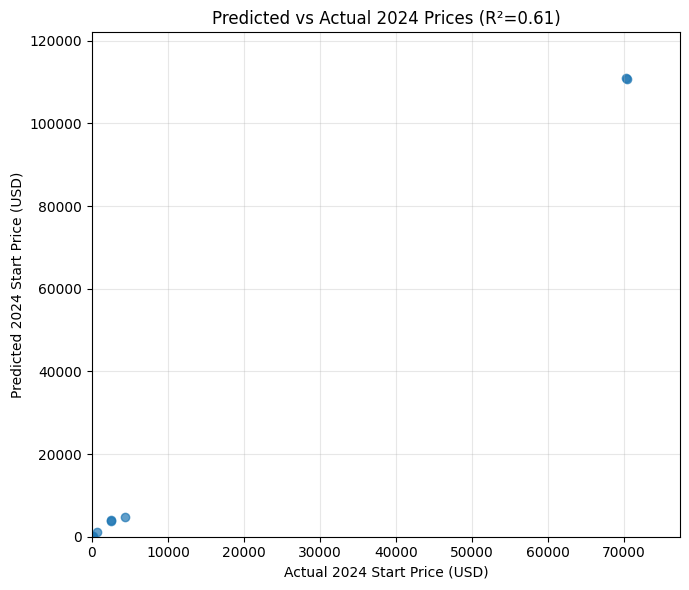

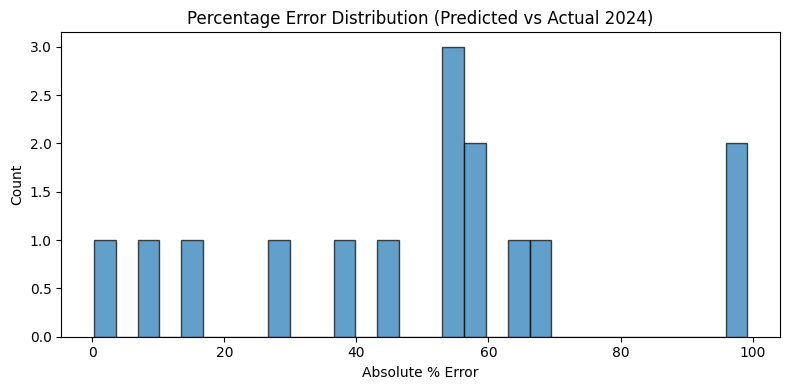

💾 Saved comparison results → comparison_2024.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from pathlib import Path

# ------------------ Paths ------------------
DATA_DIR = Path(".")  # current Colab directory
file_2023 = DATA_DIR / "coins_history_2023.csv"
file_2024 = DATA_DIR / "coins_history_2024.csv"

# ------------------ Load Data ------------------
print("📥 Loading data...")
df_2023 = pd.read_csv(file_2023, parse_dates=["timestamp_iso"])
df_2024 = pd.read_csv(file_2024, parse_dates=["timestamp_iso"])

# Clean and sort
df_2023 = df_2023.sort_values(["coin_id", "timestamp_iso"]).dropna(subset=["price", "volume_24h", "market_cap"])
df_2024 = df_2024.sort_values(["coin_id", "timestamp_iso"]).dropna(subset=["price"])

# ------------------ Feature Engineering ------------------
df_2023["price_lag1"] = df_2023.groupby("coin_id")["price"].shift(1)
df_2023["price_lag2"] = df_2023.groupby("coin_id")["price"].shift(2)
df_2023["ret1"] = df_2023.groupby("coin_id")["price"].pct_change()
df_2023["vol_lag1"] = df_2023.groupby("coin_id")["volume_24h"].shift(1)
df_2023["mcap_lag1"] = df_2023.groupby("coin_id")["market_cap"].shift(1)
df_2023["target_next"] = df_2023.groupby("coin_id")["price"].shift(-1)

df_2023 = df_2023.dropna(subset=["price_lag1","ret1","vol_lag1","mcap_lag1","target_next"])

features = ["price_lag1","price_lag2","ret1","vol_lag1","mcap_lag1"]
X = df_2023[features].astype(float)
y = df_2023["target_next"].astype(float)

# ------------------ Train Model ------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_scaled, y)
print("✅ Model trained successfully on 2023 data!")

# ------------------ Predict 2024 Start Prices ------------------
latest_2023 = df_2023.groupby("coin_id").tail(1).copy()

preds = []
for _, row in latest_2023.iterrows():
    cid = row["coin_id"]
    feat = row[features].values.reshape(1, -1)
    feat_scaled = scaler.transform(feat)
    pred_price = model.predict(feat_scaled)[0]
    preds.append([cid, row["timestamp_iso"], row["price"], pred_price])

pred_df = pd.DataFrame(preds, columns=["coin_id","timestamp_iso","last_price_2023","predicted_price_2024_start"])
pred_df.to_csv("predicted_2024.csv", index=False)
print(f"💾 Saved predictions → predicted_2024.csv ({len(pred_df)} coins)")

# ------------------ Compare with Actual 2024 Data ------------------
act_start = (
    df_2024.sort_values(["coin_id", "timestamp_iso"])
          .groupby("coin_id", as_index=False)
          .first()[["coin_id","timestamp_iso","price"]]
          .rename(columns={"price":"actual_price_2024_start"})
)

merged = pred_df.merge(act_start, on="coin_id", how="inner")
merged["abs_error"] = (merged["actual_price_2024_start"] - merged["predicted_price_2024_start"]).abs()
merged["pct_error"] = 100 * merged["abs_error"] / merged["actual_price_2024_start"].replace(0, np.nan)

# ------------------ Evaluation Metrics ------------------
mae = mean_absolute_error(merged["actual_price_2024_start"], merged["predicted_price_2024_start"])
r2 = r2_score(merged["actual_price_2024_start"], merged["predicted_price_2024_start"])
mean_pct_error = merged["pct_error"].mean()

print(f"\n📊 Evaluation Results:")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean % Error: {mean_pct_error:.2f}%")

# ------------------ Visualization ------------------
plt.figure(figsize=(7,6))
# Plot the prices with adjusted axis limits
plt.scatter(merged["actual_price_2024_start"], merged["predicted_price_2024_start"], alpha=0.7)
plt.xlabel("Actual 2024 Start Price (USD)")
plt.ylabel("Predicted 2024 Start Price (USD)")
plt.title(f"Predicted vs Actual 2024 Prices (R²={r2:.2f})")
plt.grid(True, alpha=0.3)
# Adjust axis limits to show a wider range
plt.xlim(0, merged["actual_price_2024_start"].max() * 1.1)
plt.ylim(0, merged["predicted_price_2024_start"].max() * 1.1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(merged["pct_error"], bins=30, edgecolor="black", alpha=0.7)
plt.title("Percentage Error Distribution (Predicted vs Actual 2024)")
plt.xlabel("Absolute % Error")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

merged.to_csv("comparison_2024.csv", index=False)
print("💾 Saved comparison results → comparison_2024.csv")